<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h6><center>Predicting TGV Retards</center></h6>



### Importing libraries

In [3]:
1 # Utilitaries
import os
import numpy as np
import pandas as pd
import resampy
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sn
from sklearn.preprocessing import StandardScaler 

# Deep learning libraries
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, f1_score


In [ ]:
# Import de preprocesing fonction

from preprocessing import preprocessing_data

link_data = "data/regularite-mensuelle-tgv-aqst.csv"
train_df_X, train_df_Y, test_df_X, test_df_Y = preprocessing_data(link_data)

### Hyperparameters

In [4]:
SEED = 42
Batch_size = 32

In [5]:
# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

### Getting the data

In [6]:
retards_df = pd.read_csv("data/regularite-mensuelle-tgv-aqst.csv", sep=';')
retards_df.head()


,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,NaN,289,11.247809,...,110,6.511118,44,8,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,NaN,8,2.875000,...,22,5.696096,5,0,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,NaN,37,9.501351,...,26,7.548387,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,NaN,12,19.912500,...,8,6.724757,6,4,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,NaN,61,7.796995,...,17,3.346487,6,0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


### Data analysis

In [7]:
retards_df.describe()

,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,commentaire_retards_depart,nb_train_retard_arrivee,retard_moyen_arrivee,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
count,8154.000000,8154.000000,8154.000000,0.0,8154.000000,8154.000000,8154.000000,0.0,8154.000000,8154.000000,...,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000
mean,169.860314,257.198308,11.349644,NaN,88.434265,11.205745,3.076737,NaN,34.516066,33.950971,...,24.434511,32.193823,11.642016,4.245892,23.266846,21.888418,19.052124,18.995179,6.714513,7.127315
std,87.390774,173.815703,26.544553,NaN,90.384803,12.476780,5.432676,NaN,29.729349,15.702663,...,21.400761,20.195926,11.225104,4.901032,16.805192,15.692521,14.947548,14.256533,8.080759,10.249453
min,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,-229.269444,NaN,0.000000,-40.109259,...,0.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,142.000000,0.000000,NaN,22.000000,5.128410,1.140258,NaN,13.000000,24.636941,...,9.000000,12.140350,4.000000,1.000000,11.764706,11.538462,8.695652,9.523810,0.000000,0.000000
50%,164.000000,221.000000,3.000000,NaN,55.000000,9.036447,2.248271,NaN,27.000000,32.441236,...,19.000000,34.932765,9.000000,3.000000,20.967742,20.000000,16.949153,17.165179,5.000000,3.703704
75%,221.000000,333.000000,10.000000,NaN,129.000000,14.219375,3.903651,NaN,47.000000,41.346717,...,33.000000,44.268749,16.000000,6.000000,32.307692,30.000000,26.923077,26.086957,10.000000,10.000000
max,786.000000,1075.000000,297.000000,NaN,596.000000,316.188095,84.516667,NaN,376.000000,299.600000,...,312.000000,299.600000,202.000000,71.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [8]:
retards_df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  8154 non-null   object 
 1   service                               8154 non-null   object 
 2   gare_depart                           8154 non-null   object 
 3   gare_arrivee                          8154 non-null   object 
 4   duree_moyenne                         8154 non-null   int64  
 5   nb_train_prevu                        8154 non-null   int64  
 6   nb_annulation                         8154 non-null   int64  
 7   commentaire_annulation                0 non-null      float64
 8   nb_train_depart_retard                8154 non-null   int64  
 9   retard_moyen_depart                   8154 non-null   float64
 10  retard_moyen_tous_trains_depart       8154 non-null   float64
 11  commentaire_retar

##### commentaire retard arrive analyze with NLP ? 

In [9]:
data_to_delete = ["commentaire_annulation", "commentaires_retard_arrivee", "nb_annulation", "commentaire_retards_depart", "nb_train_retard_sup_15","retard_moyen_trains_retard_sup15","nb_train_retard_sup_30", "nb_train_retard_sup_60"]

In [10]:
# Drop the specified columns from the DataFrame
retards_df = retards_df.drop(columns=data_to_delete)
retards_df.head()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,retard_moyen_tous_trains_arrivee,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,289,11.247809,3.693179,147,28.436735,6.511118,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,8,2.875000,0.095796,34,21.524020,5.696096,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,37,9.501351,1.003981,26,55.692308,7.578947,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156,102,12,19.912500,1.966667,13,48.623077,6.790686,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,61,7.796995,0.886889,71,12.405164,3.346487,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


In [11]:
retards_df['total_retard_mean'] = retards_df['retard_moyen_depart'] + retards_df['retard_moyen_arrivee']
retards_df['total_retard_alltrains_mean'] = retards_df['retard_moyen_tous_trains_depart'] + retards_df['retard_moyen_tous_trains_arrivee']

retard_columns_to_delete = ["retard_moyen_depart","retard_moyen_tous_trains_depart", "retard_moyen_arrivee", "retard_moyen_tous_trains_arrivee"]
retards_df = retards_df.drop(columns=retard_columns_to_delete)
retards_df.head()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_train_depart_retard,nb_train_retard_arrivee,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,total_retard_mean,total_retard_alltrains_mean
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,289,147,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336,39.684543,10.204297
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,8,34,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000,24.399020,5.791892
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,37,26,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000,65.193659,8.582928
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156,102,12,13,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000,68.535577,8.757353
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,61,71,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000,20.202159,4.233376


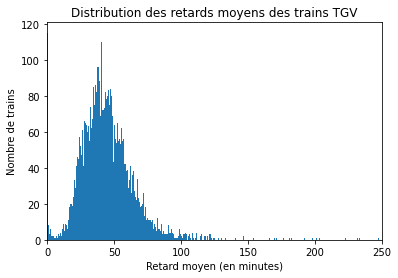

In [12]:
plt.hist(retards_df['total_retard_mean'],bins=1000)

# Add labels and title
plt.xlabel('Retard moyen (en minutes)')
plt.xlim([0, 250])
plt.ylabel('Nombre de trains')
plt.title('Distribution des retards moyens des trains TGV')
plt.show()

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

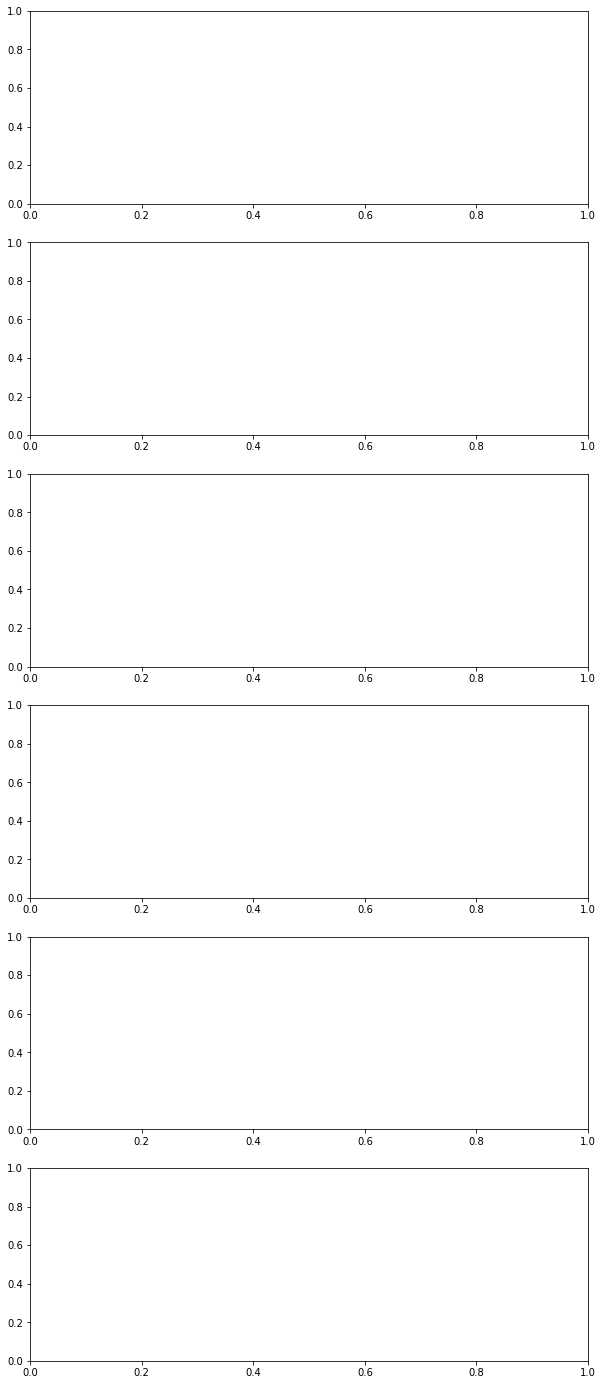

In [17]:
fig, ax = plt.subplots(6,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sn.histplot(retards_df['duree_moyenne'], color='b', bins=1000, ax=ax[0]);
sn.histplot(retards_df['nb_train_prevu'], color='b', bins=100, ax=ax[1]);
sn.histplot(retards_df['nb_train_depart_retard'], color='b', bins=100, ax=ax[2]);
sn.histplot(retards_df['nb_train_retard_arrivee'], color='b', bins=100, ax=ax[3]);
sn.histplot(retards_df['total_retard_mean'], color='b', bins=100, ax=ax[4]);
sn.histplot(retards_df['total_retard_alltrains_mean'], color='b', bins=100, ax=ax[5]);


In [ ]:
scaler = StandardScaler()
columns_to_standardize = retards_df.columns.drop(["date","service", "gare_depart","gare_arrivee"])
retards_df[columns_to_standardize] = scaler.fit_transform(retards_df[columns_to_standardize])


In [ ]:
retards_df.describe()

,duree_moyenne,nb_train_prevu,nb_train_depart_retard,nb_train_retard_arrivee,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,total_retard_mean,total_retard_alltrains_mean
count,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03
mean,1.463959e-16,3.485616e-17,8.365477e-17,2.091369e-17,6.099827e-17,1.394246e-16,6.971231e-17,-1.185109e-16,-2.788492e-17,8.365477e-17,2.230794e-16,-1.394246e-16
std,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00
min,-1.943806e+00,-1.479809e+00,-9.784796e-01,-1.161081e+00,-1.384588e+00,-1.394917e+00,-1.274677e+00,-1.332466e+00,-8.309770e-01,-6.954275e-01,-3.477838e+00,-4.477449e+01
25%,-7.994505e-01,-6.628019e-01,-7.350610e-01,-7.237759e-01,-6.844817e-01,-6.595875e-01,-6.928967e-01,-6.643937e-01,-8.309770e-01,-6.954275e-01,-5.859718e-01,-3.767948e-01
50%,-6.706284e-02,-2.082696e-01,-3.699329e-01,-2.528319e-01,-1.368176e-01,-1.203461e-01,-1.406987e-01,-1.283701e-01,-2.121853e-01,-3.340491e-01,-1.156556e-01,-1.191971e-01
75%,5.852199e-01,4.361306e-01,4.488390e-01,4.199453e-01,5.380123e-01,5.169392e-01,5.266038e-01,4.974710e-01,4.066064e-01,2.802941e-01,4.403838e-01,2.640902e-01
max,7.050830e+00,4.705282e+00,5.615954e+00,1.148713e+01,4.566319e+00,4.977936e+00,5.415794e+00,5.682292e+00,1.154486e+01,9.061789e+00,1.520437e+01,1.564519e+01


In [ ]:
nan_counts = retards_df.isna().sum()

# Display the resulting Series
print(nan_counts)

date                                    0
service                                 0
gare_depart                             0
gare_arrivee                            0
duree_moyenne                           0
nb_train_prevu                          0
nb_train_depart_retard                  0
nb_train_retard_arrivee                 0
prct_cause_externe                      0
prct_cause_infra                        0
prct_cause_gestion_trafic               0
prct_cause_materiel_roulant             0
prct_cause_gestion_gare                 0
prct_cause_prise_en_charge_voyageurs    0
total_retard_mean                       0
total_retard_alltrains_mean             0
dtype: int64


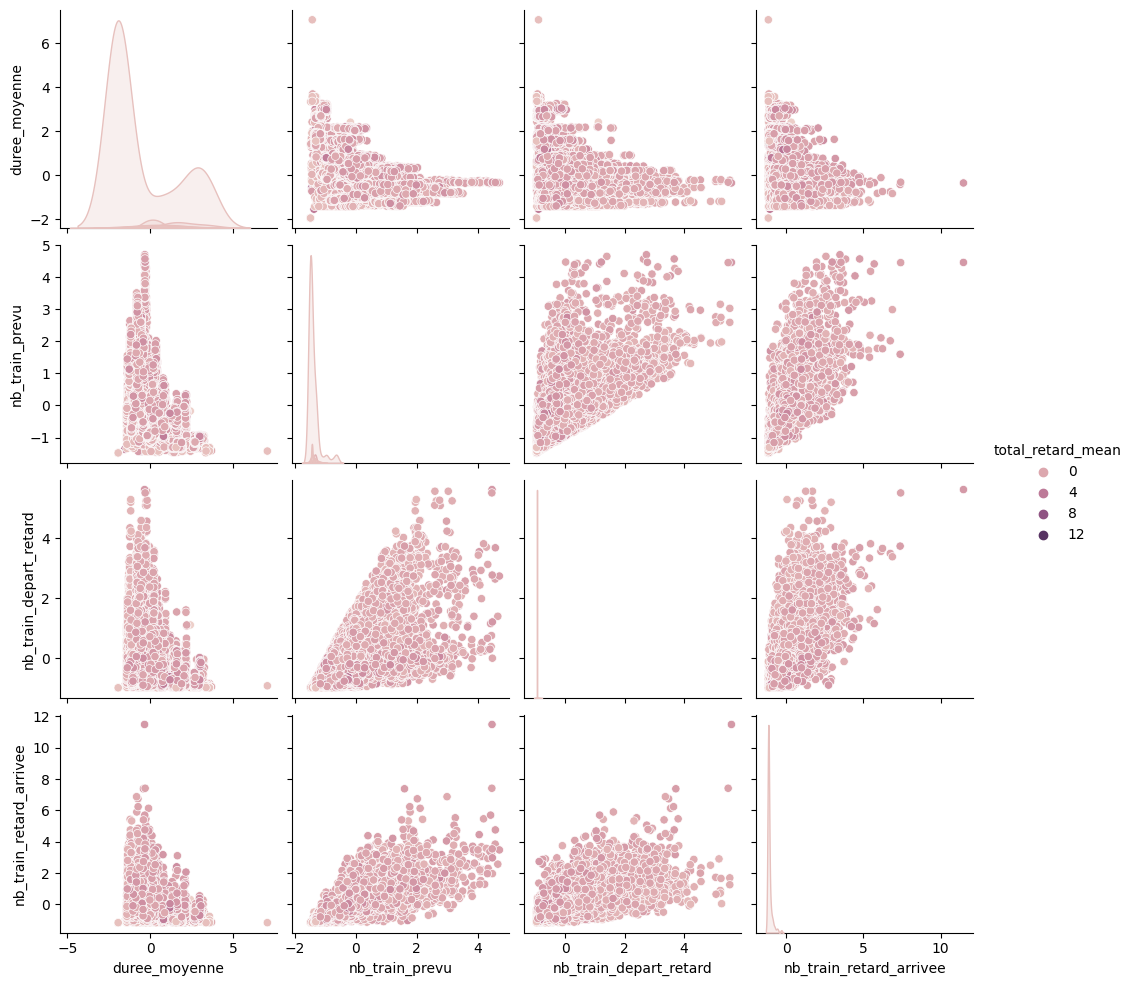

In [ ]:
sn.pairplot(retards_df[["duree_moyenne","nb_train_prevu","nb_train_depart_retard","nb_train_retard_arrivee","total_retard_mean"]], hue = 'total_retard_mean', diag_kind='kde');

In [ ]:
dummies = pd.get_dummies(retards_df[["gare_depart","gare_arrivee","service"]])
dummies

,gare_depart_AIX EN PROVENCE TGV,gare_depart_ANGERS SAINT LAUD,gare_depart_ANGOULEME,gare_depart_ANNECY,gare_depart_ARRAS,gare_depart_AVIGNON TGV,gare_depart_BARCELONA,gare_depart_BELLEGARDE (AIN),gare_depart_BESANCON FRANCHE COMTE TGV,gare_depart_BORDEAUX ST JEAN,...,gare_arrivee_STUTTGART,gare_arrivee_TOULON,gare_arrivee_TOULOUSE MATABIAU,gare_arrivee_TOURCOING,gare_arrivee_TOURS,gare_arrivee_VALENCE ALIXAN TGV,gare_arrivee_VANNES,gare_arrivee_ZURICH,service_International,service_National
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Concatenate the original DataFrame with the dummy variables
retards_w_dummies_df = pd.concat([retards_df, dummies], axis=1)

In [ ]:
retards_w_dummies_df = retards_w_dummies_df.drop(columns=["service","gare_depart","gare_arrivee"])

In [ ]:
fitting_df = retards_w_dummies_df[retards_w_dummies_df['date'] < '2023']
validate_df = retards_w_dummies_df[retards_w_dummies_df['date'] >= '2023']

In [ ]:
fitting_df = fitting_df.drop("date",axis=1)
validate_df = validate_df.drop("date",axis=1)

In [ ]:
data_to_mantain = ['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs', 'total_retard_mean', 'total_retard_alltrains_mean']

In [ ]:
df_Y = fitting_df[data_to_mantain]
df_X = fitting_df.drop(columns=data_to_mantain)

validate_df_X = validate_df[data_to_mantain]
validate_df_Y = validate_df.drop(columns=data_to_mantain)

In [ ]:
train_df_X,test_df_X , train_df_Y,test_df_Y = train_test_split(df_X,df_Y, test_size=0.2, random_state=SEED)

In [14]:
train_df_X = train_df_X.reset_index(drop=True)
train_df_Y = train_df_Y.reset_index(drop=True)
test_df_X = test_df_X.reset_index(drop=True)
test_df_Y = test_df_Y.reset_index(drop=True)

NameError: name 'train_df_X' is not defined

### DataLoaders

In [15]:
train_df_X.shape

NameError: name 'train_df_X' is not defined

In [16]:
train_dataloader = tf.data.Dataset.from_tensor_slices((train_df_X.values,train_df_Y.values)).batch(batch_size=Batch_size)
test_dataloader = tf.data.Dataset.from_tensor_slices((test_df_X.values,test_df_Y.values)).batch(batch_size=Batch_size)
val_dataloader =tf.data.Dataset.from_tensor_slices((validate_df_X.values,validate_df_Y.values)).batch(batch_size=Batch_size)

NameError: name 'train_df_X' is not defined

###  Models


to do =  \n
models to test =
regresion
decision tree and relationed
NN
set the metrics parameters

In [291]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.flatten = tf.keras.layers.Flatten()
    self.d1 = tf.keras.layers.Dense(128, activation='relu')
    self.d2 = tf.keras.layers.Dense(64, activation='relu')
    self.d3 = tf.keras.layers.Dense(32, activation='relu')
    self.d4 = tf.keras.layers.Dense(32, activation='relu')
    self.d5 = tf.keras.layers.Dense(16, activation='relu')
    self.d6 = tf.keras.layers.Dense(8)
    self.dropout1 = tf.keras.layers.Dropout(0.4)
    self.dropout2 = tf.keras.layers.Dropout(0.2)

    
  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    x = self.dropout1(x)
    x = self.d2(x)
    x = self.dropout1(x)
    x = self.d3(x)
    x = self.dropout2(x)
    x = self.d4(x)
    x = self.dropout2(x)
    x = self.d5(x)
    x = self.dropout2(x)
    x = self.d6(x)
    return x

# Create an instance of the model
model = MyModel()

### Training Function   

In [297]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0, min_delta = 5e-4, mode='min',verbose=1)

In [296]:
loss_object = tf.keras.losses.MeanSquaredError()

optimizer = tf.keras.optimizers.AdamW(learning_rate = 5e-3,weight_decay= 2e-3)

In [298]:
model.compile(loss=loss_object,optimizer=optimizer)
testhistori = model.fit(train_dataloader,epochs=100,validation_data=test_dataloader,batch_size=Batch_size,callbacks=[reduce_lr])

Epoch 1/100
186/186 [==============================] - 1s 1ms/step - loss: 0.9188 - val_loss: 0.9166 - lr: 0.0050
Epoch 2/100
186/186 [==============================] - 0s 1ms/step - loss: 0.9193 - val_loss: 0.9201 - lr: 0.0050
Epoch 3/100
186/186 [==============================] - 0s 982us/step - loss: 0.9185 - val_loss: 0.9212 - lr: 0.0050
Epoch 4/100
186/186 [==============================] - 0s 1ms/step - loss: 0.9227 - val_loss: 0.9191 - lr: 0.0050
Epoch 5/100
186/186 [==============================] - 0s 1ms/step - loss: 0.9189 - val_loss: 0.9185 - lr: 0.0050
Epoch 6/100
186/186 [==============================] - 0s 1ms/step - loss: 0.9163 - val_loss: 0.9228 - lr: 0.0050
Epoch 7/100
186/186 [==============================] - 0s 1ms/step - loss: 0.9214 - val_loss: 0.9230 - lr: 0.0050
Epoch 8/100
186/186 [==============================] - 0s 1ms/step - loss: 0.9237 - val_loss: 0.9248 - lr: 0.0050
Epoch 9/100
186/186 [==============================] - 0s 987us/step - loss: 0.9206 - 

In [ ]:
print(testhistori.history.keys())

dict_keys(['loss', 'val_loss', 'lr'])


Text(0.5, 1.0, 'Losses x Epochs')

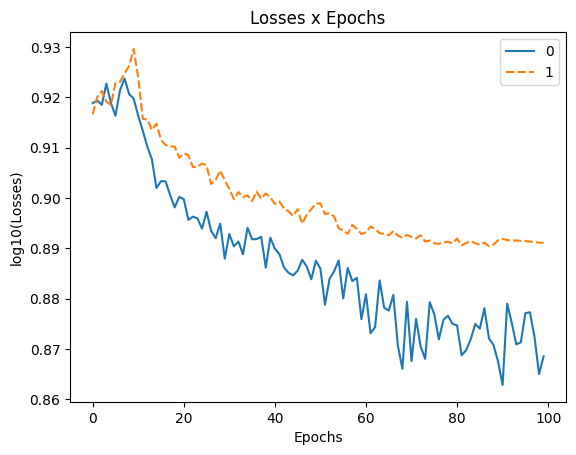

In [299]:
ax = sn.lineplot(data=[testhistori.history["loss"],testhistori.history["val_loss"]])
ax.set_ylabel("log10(Losses)")
ax.set_xlabel("Epochs")
ax.set_title("Losses x Epochs") 